In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
CONFIG = {
    "batch_size": 256,
    "lr": 1e-3,
    "epochs": 15,
    "embedding_dim": 64,    
    "temperature": 0.07,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

print(f"Running on device: {CONFIG['device']}")

Running on device: cuda


### Dataset

In [3]:
def get_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    return train_loader, test_loader

In [4]:
train_loader, test_loader = get_data(CONFIG["batch_size"])

### Model

In [5]:
class CNN(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(64 * 7 * 7, embedding_dim)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        return x

class ContrastiveModel(nn.Module):
    def __init__(self, embedding_dim, num_classes=10):
        super().__init__()
        self.image_encoder = CNN(embedding_dim)
        self.label_encoder = nn.Embedding(num_classes, embedding_dim)

    def forward(self, images, labels):
        # encode images
        img_emb = self.image_encoder(images)
        
        # encode labels
        lbl_emb = self.label_encoder(labels)
        
        img_emb = F.normalize(img_emb, p=2, dim=1)
        lbl_emb = F.normalize(lbl_emb, p=2, dim=1)
        
        return img_emb, lbl_emb

In [6]:
def info_nce_loss(image_embeddings, label_embeddings, temperature=0.1):
   
    # compute similarity
    # shape: (batch_size, batch_size)
    logits = torch.matmul(image_embeddings, label_embeddings.T) / temperature
    
    # targets are the indices [0, 1, ..., batch_size-1]
    batch_size = image_embeddings.shape[0]
    labels = torch.arange(batch_size).to(image_embeddings.device)
    
    loss = F.cross_entropy(logits, labels)
    
    return loss

### Train

Starting training for 15 epochs...
Epoch 1/15 - Loss: 3.6473
Epoch 2/15 - Loss: 3.3213
Epoch 3/15 - Loss: 3.3020
Epoch 4/15 - Loss: 3.2932
Epoch 5/15 - Loss: 3.2860
Epoch 6/15 - Loss: 3.2833
Epoch 7/15 - Loss: 3.2784
Epoch 8/15 - Loss: 3.2752
Epoch 9/15 - Loss: 3.2756
Epoch 10/15 - Loss: 3.2741
Epoch 11/15 - Loss: 3.2723
Epoch 12/15 - Loss: 3.2695
Epoch 13/15 - Loss: 3.2700
Epoch 14/15 - Loss: 3.2668
Epoch 15/15 - Loss: 3.2693


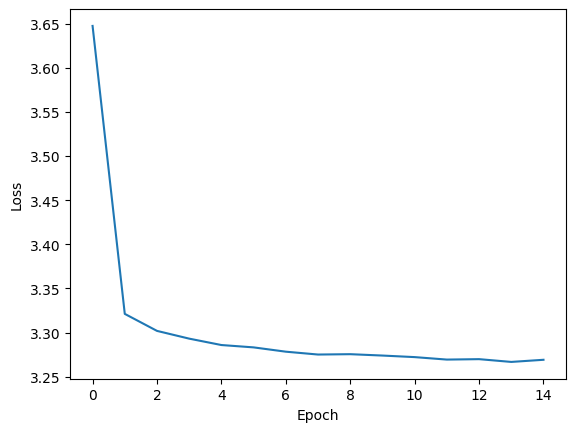

In [7]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    
    for batch_idx, (images, targets) in enumerate(loader):
        images, targets = images.to(CONFIG["device"]), targets.to(CONFIG["device"])
        
        optimizer.zero_grad()
        
        # forward pass
        img_emb, lbl_emb = model(images, targets)
        
        # calculate Loss
        loss = info_nce_loss(img_emb, lbl_emb, CONFIG["temperature"])
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(loader)

# --- Initialize ---
model = ContrastiveModel(CONFIG["embedding_dim"]).to(CONFIG["device"])
optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])

# --- Training ---
print(f"Starting training for {CONFIG['epochs']} epochs...")
loss_history = []

for epoch in range(1, CONFIG["epochs"] + 1):
    avg_loss = train(model, train_loader, optimizer)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch}/{CONFIG['epochs']} - Loss: {avg_loss:.4f}")

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Train: MSE vs InfoNCE

In [8]:
def reset():
    model = ContrastiveModel(CONFIG["embedding_dim"]).to(CONFIG["device"])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
    return model, optimizer

def train_epoch(model, optimizer, loader, loss_type="infonce"):
    model.train()
    total_loss = 0
    
    mse_criterion = nn.MSELoss()
    
    for images, targets in loader:
        images, targets = images.to(CONFIG["device"]), targets.to(CONFIG["device"])
        optimizer.zero_grad()
        
        # forward
        img_emb, lbl_emb = model(images, targets)
        
        # --- LOSS SWITCHING ---
        if loss_type == "infonce":
            loss = info_nce_loss(img_emb, lbl_emb, CONFIG["temperature"])
        elif loss_type == "mse":
            loss = mse_criterion(img_emb, lbl_emb)
            
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / len(loader)

### Evaluation

In [9]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    
    # pre-compute all 10 label embeddings
    all_labels = torch.arange(10).to(CONFIG["device"])
    with torch.no_grad():
        label_prototypes = model.label_encoder(all_labels)
        label_prototypes = F.normalize(label_prototypes, p=2, dim=1) # Normalize
    
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(CONFIG["device"]), targets.to(CONFIG["device"])
            
            # encode images
            img_emb = model.image_encoder(images)
            img_emb = F.normalize(img_emb, p=2, dim=1)
            
            similarity = torch.matmul(img_emb, label_prototypes.T)
            
            # prediction is the index with highest dot product
            predictions = torch.argmax(similarity, dim=1)
            
            correct += (predictions == targets).sum().item()
            total += targets.size(0)
            
    return 100 * correct / total

accuracy = evaluate_accuracy(model, test_loader)
print(f"Test Set Accuracy (using dot product similarity): {accuracy:.2f}%")

Test Set Accuracy (using dot product similarity): 98.86%


### Evaluate: MSE vs InfoNCE

In [10]:
# --- InfoNCE ---
print("Running Experiment: InfoNCE...")
model_nce, opt_nce = reset()
nce_accuracies = []
nce_losses = []

for epoch in range(1, CONFIG["epochs"] + 1):
    loss = train_epoch(model_nce, opt_nce, train_loader, loss_type="infonce")
    acc = evaluate_accuracy(model_nce, test_loader)
    nce_losses.append(loss)
    nce_accuracies.append(acc)
    print(f"InfoNCE Epoch {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}%")

# --- MSE ---
print("\nRunning Experiment: MSE...")
model_mse, opt_mse = reset()
mse_accuracies = []
mse_losses = []

for epoch in range(1, CONFIG["epochs"] + 1):
    loss = train_epoch(model_mse, opt_mse, train_loader, loss_type="mse")
    acc = evaluate_accuracy(model_mse, test_loader)
    mse_losses.append(loss)
    mse_accuracies.append(acc)
    print(f"MSE Epoch {epoch}     | Loss: {loss:.4f} | Acc: {acc:.2f}%")

Running Experiment: InfoNCE...
InfoNCE Epoch 1 | Loss: 3.6611 | Acc: 97.87%
InfoNCE Epoch 2 | Loss: 3.3170 | Acc: 98.66%
InfoNCE Epoch 3 | Loss: 3.3007 | Acc: 98.88%
InfoNCE Epoch 4 | Loss: 3.2909 | Acc: 98.60%
InfoNCE Epoch 5 | Loss: 3.2882 | Acc: 98.90%
InfoNCE Epoch 6 | Loss: 3.2825 | Acc: 98.90%
InfoNCE Epoch 7 | Loss: 3.2769 | Acc: 98.93%
InfoNCE Epoch 8 | Loss: 3.2755 | Acc: 99.01%
InfoNCE Epoch 9 | Loss: 3.2731 | Acc: 99.01%
InfoNCE Epoch 10 | Loss: 3.2711 | Acc: 99.02%
InfoNCE Epoch 11 | Loss: 3.2716 | Acc: 98.94%
InfoNCE Epoch 12 | Loss: 3.2709 | Acc: 98.98%
InfoNCE Epoch 13 | Loss: 3.2685 | Acc: 99.07%
InfoNCE Epoch 14 | Loss: 3.2676 | Acc: 99.03%
InfoNCE Epoch 15 | Loss: 3.2670 | Acc: 99.08%

Running Experiment: MSE...
MSE Epoch 1     | Loss: 0.0044 | Acc: 97.13%
MSE Epoch 2     | Loss: 0.0016 | Acc: 97.92%
MSE Epoch 3     | Loss: 0.0012 | Acc: 98.15%
MSE Epoch 4     | Loss: 0.0010 | Acc: 98.26%
MSE Epoch 5     | Loss: 0.0009 | Acc: 98.44%
MSE Epoch 6     | Loss: 0.0007 | Ac

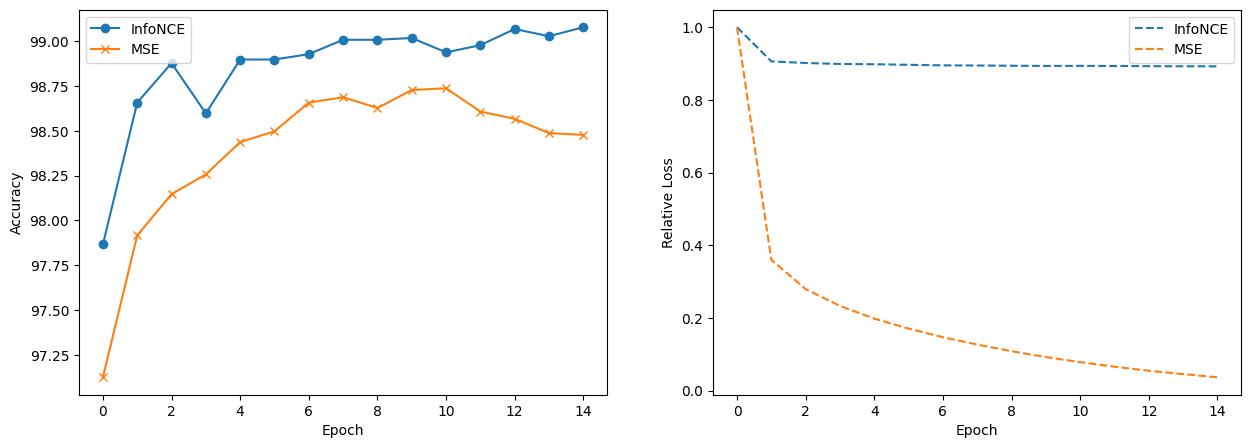

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(nce_accuracies, label="InfoNCE", marker='o')
ax1.plot(mse_accuracies, label="MSE", marker='x')
#ax1.set_title("Test Accuracy: InfoNCE vs MSE")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(False)

# Loss
norm_nce_loss = [l / nce_losses[0] for l in nce_losses]
norm_mse_loss = [l / mse_losses[0] for l in mse_losses]

ax2.plot(norm_nce_loss, label="InfoNCE", linestyle='--')
ax2.plot(norm_mse_loss, label="MSE", linestyle='--')
#ax2.set_title("Relative Loss Decrease (Normalized)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Relative Loss")
ax2.legend()
ax2.grid(False)

plt.show()

### Plot

In [ ]:
from sklearn.manifold import TSNE

def visualize_latent_space(model, loader, num_batches=5):
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for i, (imgs, lbls) in enumerate(loader):
            if i >= num_batches: break
            imgs = imgs.to(CONFIG["device"])
            emb = model.image_encoder(imgs)
            embeddings.append(emb.cpu().numpy())
            labels.append(lbls.numpy())
            
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    
    # run t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    
    # plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title("t-SNE: MNIST")
    plt.show()

visualize_latent_space(model, test_loader)

Generating t-SNE for InfoNCE...
Generating t-SNE for MSE...


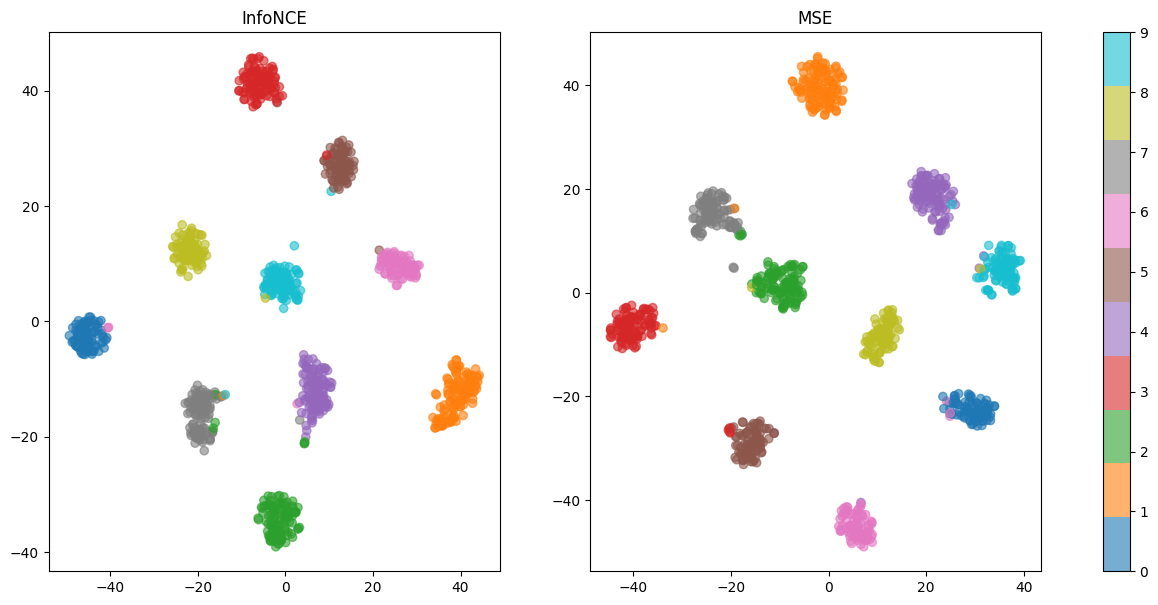

In [ ]:
from sklearn.manifold import TSNE

def plot_tsne(model_nce, model_mse, loader):
   
    def get_embeddings(model):
        model.eval()
        embs, lbls = [], []
        with torch.no_grad():
            for images, targets in loader:
                images = images.to(CONFIG["device"])
                output = model.image_encoder(images)
                output = F.normalize(output, p=2, dim=1)
                embs.append(output.cpu().numpy())
                lbls.append(targets.numpy())
            return np.concatenate(embs), np.concatenate(lbls)

    print("Generating t-SNE for InfoNCE...")
    nce_embs, nce_lbls = get_embeddings(model_nce)
    print("Generating t-SNE for MSE...")
    mse_embs, mse_lbls = get_embeddings(model_mse)

    # reduce dimensionality
    limit = 1000
    tsne = TSNE(n_components=2, random_state=42)
    
    nce_2d = tsne.fit_transform(nce_embs[:limit])
    mse_2d = tsne.fit_transform(mse_embs[:limit])
    labels = nce_lbls[:limit]

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # InfoNCE plot
    scatter1 = ax1.scatter(nce_2d[:, 0], nce_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    ax1.set_title("InfoNCE")
    
    # MSE plot
    scatter2 = ax2.scatter(mse_2d[:, 0], mse_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    ax2.set_title("MSE")
    
    plt.colorbar(scatter1, ax=[ax1, ax2])
    plt.show()

# Run it
plot_tsne(model_nce, model_mse, test_loader)

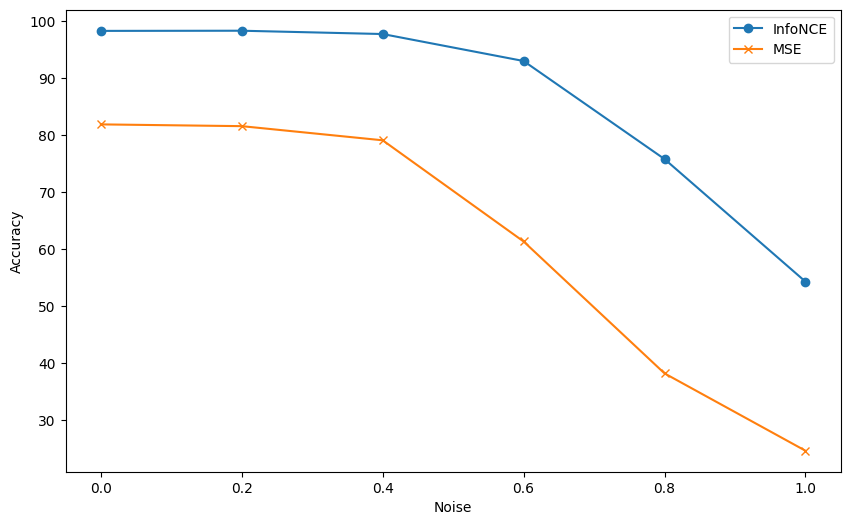

In [ ]:
def test_noise(model, loader, noise_levels=[0.0, 0.1, 0.3, 0.5, 0.8]):
    model.eval()
    accuracies = []
    
    for noise in noise_levels:
        correct = 0
        total = 0
        
        all_labels = torch.arange(10).to(CONFIG["device"])
        with torch.no_grad():
            prototypes = F.normalize(model.label_encoder(all_labels), dim=1)

        for images, targets in loader:
            images, targets = images.to(CONFIG["device"]), targets.to(CONFIG["device"])
            
            # --- NOISE ---
            # add gaussian noise
            images = images + torch.randn_like(images) * noise
            images = torch.clamp(images, 0, 1)
            
            with torch.no_grad():
                img_emb = F.normalize(model.image_encoder(images), dim=1)
                similarity = torch.matmul(img_emb, prototypes.T)
                predictions = torch.argmax(similarity, dim=1)
                
            correct += (predictions == targets).sum().item()
            total += targets.size(0)
            
        accuracies.append(100 * correct / total)
    
    return accuracies

# Run
noise_levels = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
nce_robustness = test_noise(model_nce, test_loader, noise_levels)
mse_robustness = test_noise(model_mse, test_loader, noise_levels)

# plot
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, nce_robustness, marker='o', label='InfoNCE')
plt.plot(noise_levels, mse_robustness, marker='x', label='MSE')
plt.xlabel("Noise")
plt.ylabel("Accuracy")
#plt.title("Robustness to Visual Noise")
plt.legend()
plt.grid(False)
plt.show()

InfoNCE Worst Failure Case:


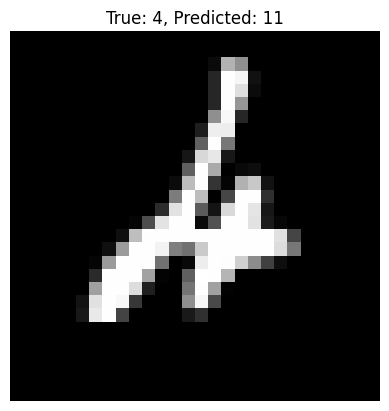

In [ ]:
def plot_negative_sample(model, loader):
    model.eval()
    images_batch, labels_batch = next(iter(loader))
    images_batch, labels_batch = images_batch.to(CONFIG["device"]), labels_batch.to(CONFIG["device"])
    
    with torch.no_grad():
        img_emb = F.normalize(model.image_encoder(images_batch), dim=1)
        lbl_emb = F.normalize(model.label_encoder(labels_batch), dim=1)
    
        # diagonals are "correct" class scores, off-diagonals are "incorrect"
        sim_matrix = torch.matmul(img_emb, lbl_emb.T)
        
    # find the image with the lowest score for its OWN label
    batch_indices = torch.arange(len(images_batch))
    correct_scores = sim_matrix[batch_indices, batch_indices]
    
    # get the index of the worst prediction
    worst_idx = torch.argmin(correct_scores).item()

    prediction_scores = sim_matrix[worst_idx]
    predicted_label = torch.argmax(prediction_scores).item()
    actual_label = labels_batch[worst_idx].item()
    
    # plot
    img = images_batch[worst_idx].cpu().squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

print("InfoNCE Worst Failure Case:")
plot_negative_sample(model_nce, test_loader)